# Geolocation project

## KMeans

#### Distributed Data and Data Engineering Spring 2020

#### By: Sam Watson

## Part 1: Compute and Visualize Clusters

Here, I will be comparing the clusters of three datasets using Euclidean and great circle (cosine) distance.

First, I will need to load my three datasets: 
- Device location data,
- Synthetic Location data, and 
- DBpedia location data

Then I will be doing kmeans clustering for each, using both Euclidean and great cirlce distance


In [1]:
#importing modules!
import pyspark
from pyspark.sql.functions import *

### Loading the Data

In [2]:
loaddata1=spark.read.format('csv').options(header='false').load("s3a://geocluster/dataset1/dataset1clean.csv")
loaddata2=spark.read.format('csv').options(header='false').load("s3a://geocluster/dataset2/dataset2clean.csv")
loaddata3=spark.read.format('csv').options(header='false').load("s3a://geocluster/dataset3/dataset3clean.csv")

In [3]:
print('Device data (data1):',loaddata1.count(),type(loaddata1))
print(loaddata1.printSchema())
print('')
print('Synthetic data (data2):',loaddata2.count(),type(loaddata2))
print(loaddata2.printSchema())
print('')
print('DBpedia data (data3):',loaddata3.count(),type(loaddata3))
print(loaddata3.printSchema())

('Device data (data1):', 94039, <class 'pyspark.sql.dataframe.DataFrame'>)
root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)

None

('Synthetic data (data2):', 9971, <class 'pyspark.sql.dataframe.DataFrame'>)
root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)

None

('DBpedia data (data3):', 450150, <class 'pyspark.sql.dataframe.DataFrame'>)
root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)

None


In [4]:
#a bit messy! time to clean it up a little bit
print(loaddata1.show(2))
print(loaddata2.show(2))
print(loaddata3.show(2))

+-----------------+------------------+--------------------+-----------------+--------------------+------------+---------+
|              _c0|               _c1|                 _c2|              _c3|                 _c4|         _c5|      _c6|
+-----------------+------------------+--------------------+-----------------+--------------------+------------+---------+
|[u'33.6894754264'| u'-117.543308253'| u'2014-03-15:10:...| u'Sorrento F41L'| u'8cc3b47e-bd01-...| u'Sorrento'| u'F41L']|
|[u'37.4321088904'| u'-121.485029632'| u'2014-03-15:10:...|    u'MeeToo 1.0'| u'ef8c7564-0a1a-...|   u'MeeToo'|  u'1.0']|
+-----------------+------------------+--------------------+-----------------+--------------------+------------+---------+
only showing top 2 rows

None
+---------------+----------------+---------------+
|            _c0|             _c1|            _c2|
+---------------+----------------+---------------+
|   [u'Latitude'|    u'Longitude'| u'LocationID']|
|[u'37.77253945'| u'-77.49954987'|

In [5]:
def mydatacleaner(loaddata):
    #removing header that transfered over incorrectly from dataset2
    X=loaddata.filter(loaddata._c0!="[u'Latitude'")
    #removing unwanted elements in strings, so that they may be converted to float
    for cols in ['_c0','_c1']:
        X=X.withColumn(cols,regexp_replace(cols,"\\[",""))
        X=X.withColumn(cols,regexp_replace(cols," ",""))
        X=X.withColumn(cols,regexp_replace(cols,'u',''))
        X=X.withColumn(cols,regexp_replace(cols,"'",""))
    #only keeping first two columns
    X=X.select("_c0","_c1")
    #converting columns to float
    X=X.withColumn('_c0',X['_c0'].cast("float").alias('latitude'))
    X=X.withColumn('_c1',X['_c1'].cast("float").alias('longitude'))
    X=X.dropna()
    X=X.filter((X._c0 !=0) & (X._c1 !=0))
    return X

In [6]:
data1=mydatacleaner(loaddata1)
data2=mydatacleaner(loaddata2)
data3=mydatacleaner(loaddata3)
print('data1',data1.show(2))
print('')
print('datat2',data2.show(2))
print('')
print('data3',data3.show(2))


+---------+-----------+
|      _c0|        _c1|
+---------+-----------+
|33.689476|-117.543304|
| 37.43211| -121.48503|
+---------+-----------+
only showing top 2 rows

('data1', None)

+---------+----------+
|      _c0|       _c1|
+---------+----------+
| 37.77254| -77.49955|
|42.090134|-87.689156|
+---------+----------+
only showing top 2 rows

('datat2', None)

+----+---------+
| _c0|      _c1|
+----+---------+
|36.7|3.2166667|
|42.5|1.5166667|
+----+---------+
only showing top 2 rows

('data3', None)


### Making and Plotting Kmeans Function

Now, I'm going to make two functions: one that does the kmeans algorithm, and another that plots it. I'll then run the two functions on each dataset with varying values for k

In [7]:
#creating a function that will calculate kmeans for a given dataset with columns "_c0", "_c1". 
#the function takes how many clusters, and why distance measure (euclidean/cosine) as input parameters

def mykmeans(data,val,dist):
    #importing libraries
    import pyspark
    from pyspark.sql.functions import *
    from pyspark.ml.feature import VectorAssembler
    from pyspark.ml.clustering import KMeans
    #parsing the data as input pairs
    vecAssembler = VectorAssembler(inputCols=["_c0","_c1"],outputCol="features")
    new = vecAssembler.transform(data).cache()
    kmeans = KMeans(k=int(val),seed=1,distanceMeasure=str(dist))
    model=kmeans.fit(new.select("features"))
    transformed=model.transform(new)
    #getting centers:
    centers=KMeans(k=int(val),seed=1,distanceMeasure='euclidean').fit(new.select("features")).clusterCenters()

    return transformed,centers

<ipython-input-7-bdb36d524467>:4: SyntaxWarning: import * only allowed at module level
  def mykmeans(data,val,dist):


In [8]:
#creating a function that takes the output of mykmeans function, and plots it

def myplotter(data,val,dist):
    #import libraries 
    import matplotlib.pyplot as plt
    import numpy as np
    #make title
    title='Latitude/Longitude with k= '+str(val)+' and '+str(dist)+' distance'
    #getting clustered data
    outputs,centers=mykmeans(data,val,dist)

    plt.figure(figsize=(6,6))
    #plot each cluster
    for i in range(val):
        dftoplot=outputs.filter(outputs.prediction==i)
        lats=dftoplot.select('_c0').collect()
        lats = np.asarray(lats)
        lats=lats.T[0]
        longs=dftoplot.select('_c1').collect()
        longs = np.asarray(longs)
        longs=longs.T[0]
        plt.scatter(lats,longs)
    #plotting centers
    for i in range(len(centers)):
        plt.scatter(centers[i][0],centers[i][1],c='black',s=30,alpha=.7)
    plt.title(title)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    return plt.show

### Kmeans on Device Data

Using k=5

In [ ]:
myplotter(data1,5,'cosine')

<function matplotlib.pyplot.show>

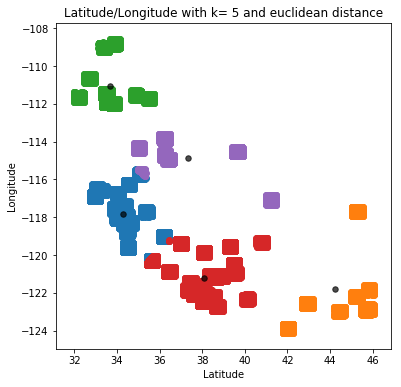

In [10]:
myplotter(data1,5,'euclidean')

### Kmeans on Synthetic Data

Using k=2, and k=4

<function matplotlib.pyplot.show>

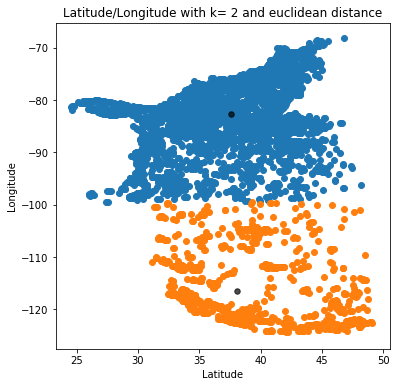

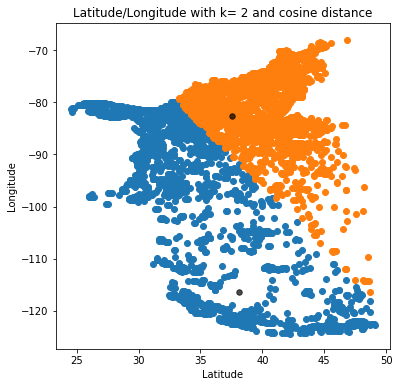

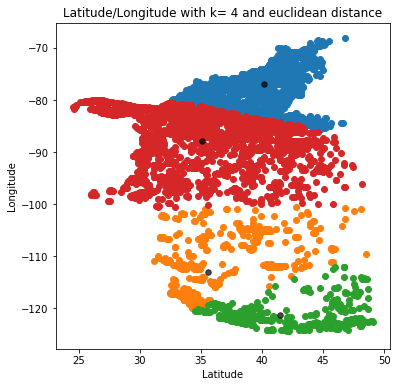

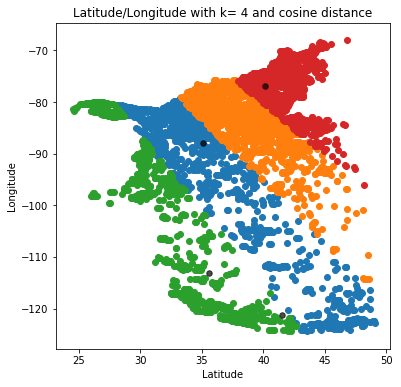

In [11]:
myplotter(data2,2,'euclidean')
myplotter(data2,2,'cosine')
myplotter(data2,4,'euclidean')
myplotter(data2,4,'cosine')

### Kmeans on DBpedia Data

Using k=6, and k=4

<function matplotlib.pyplot.show>

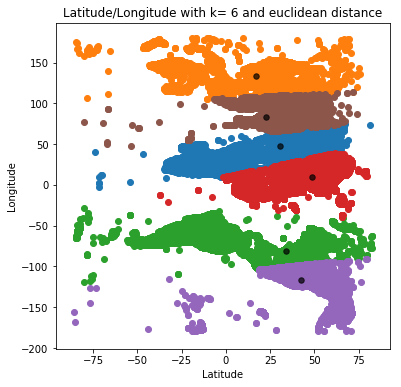

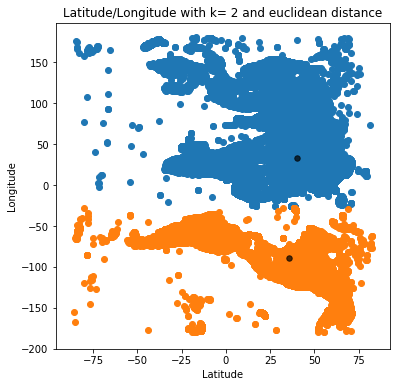

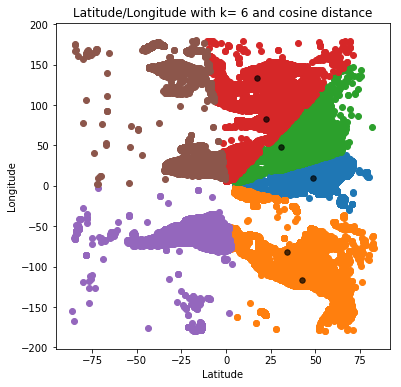

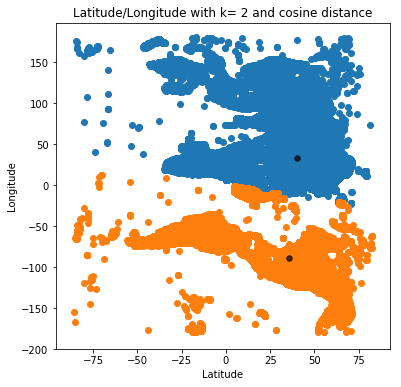

In [12]:
myplotter(data3,6,'euclidean')
myplotter(data3,2,'euclidean')
myplotter(data3,6,'cosine')
myplotter(data3,2,'cosine')

### Some Overall Findings:

For the Synthetic dataset, if you chose either euclidean distance, then the decision boundary is basically a horizontal line. for cosine distance, the decision line is more at a 45 degree angle.

When looking at the last dataset, the value for k that makes to me would be k=6. This is because the dataset covers the entire world, and there are six populated continents in the world.

## Part 2: Runtime Analysis

Thank you, you've been a great audience. For my last trick, I will compare the runtimes of my k-means implementation for all three datasets. Then, I'll compare this overall runtime to that done with three threads going on. Fear the might of paralell processing! Muhuhahaha

In [18]:
%%timeit -n 3
mykmeans(data1,4,'euclidean')

3 loops, best of 3: 3.84 s per loop


In [19]:
%%timeit -n 3
mykmeans(data2,4,'euclidean')

3 loops, best of 3: 2.13 s per loop


In [20]:
%%timeit -n 3
mykmeans(data3,4,'euclidean')

3 loops, best of 3: 8.48 s per loop


In [21]:
%%timeit -n 3
mykmeans(data1,4,'euclidean')
mykmeans(data2,4,'euclidean')
mykmeans(data3,4,'euclidean')

3 loops, best of 3: 14.3 s per loop


In [23]:
%%timeit -n 3
from multiprocessing.pool import ThreadPool

# allow up to 3 concurrent threads
pool = ThreadPool(3)
# each dataset
parameters = [ data1, data2, data3]

pool.map(lambda dataset: mykmeans(dataset,4,'euclidean'), parameters)

3 loops, best of 3: 10.6 s per loop


In [24]:
#manually recorded the outputs of the runtimes to put in a bar graph

specs='3 loops, best of 3'

l=['dataset 1','dataset 2','dataset 3']
lvals=[3.84,2.13,8.48]

l1=['No Threading','Threading']
l1vals=[14.3,10.6]

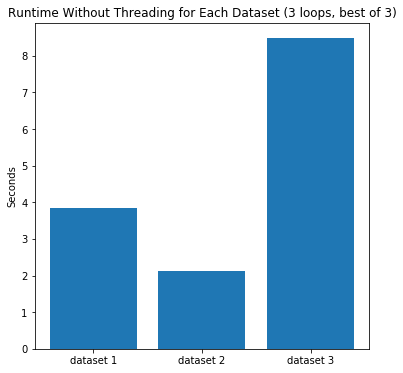

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))

plt.bar(l,lvals)
plt.title('Runtime Without Threading for Each Dataset ('+str(specs)+')')
plt.ylabel('Seconds')
plt.show()

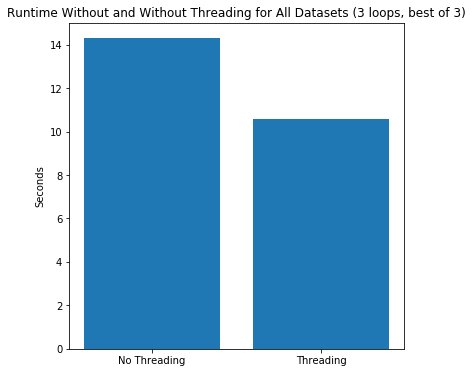

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.bar(l1,l1vals)
plt.title('Runtime Without and Without Threading for All Datasets ('+str(specs)+')')
plt.ylabel('Seconds')
plt.show()